First we load in the loneliness data, a loneliness score is given for each MSOA (Middle Layer Super Output Area). Since we plan to compare to Ofsted school data which is given for local authorities we combine MSOAs

In [1]:
#This dataset file is also needed https://geoportal.statistics.gov.uk/datasets/postcode-to-output-area-to-lower-layer-super-output-area-to-middle-layer-super-output-area-to-local-authority-district-february-2022-lookup-in-the-uk/about

import pandas as pd

loneliness_data = pd.read_csv("msoa_loneliness.csv")
# msoa_la_code_df = pd.read_csv('PCD_OA_LSOA_MSOA_LAD_FEB22_UK_LU.csv', encoding='latin-1') #change encoding to fix read error
# #get LA code from msoa code
# msoa_code_rows = msoa_la_code_df.loc[msoa_la_code_df['msoa11cd'].isin(loneliness_data['msoa11cd'])]
# msoa_code_conv = dict(zip(msoa_code_rows['msoa11cd'],msoa_code_rows['ladcd']))

msoa_la_code_df = pd.read_csv('Output_Area_to_LSOA_to_MSOA_to_Local_Authority_District_(December_2017)_Lookup_with_Area_Classifications_in_Great_Britain.csv', encoding='latin-1') #change encoding to fix read error
msoa_code_rows = msoa_la_code_df.loc[msoa_la_code_df['MSOA11CD'].isin(loneliness_data['msoa11cd'])]
msoa_code_conv = dict(zip(msoa_code_rows['MSOA11CD'],msoa_code_rows['LAD17CD']))

loneliness_data['LA code'] = loneliness_data['msoa11cd'].apply(lambda x: msoa_code_conv[x])
#print(loneliness_data)



LA_counts = loneliness_data.groupby('LA code').count()
LA_index_sum = loneliness_data.groupby('LA code').sum()['loneills_2018']
LA_index_average = LA_index_sum / LA_counts['msoa11cd']


# 1st attempted to merge by name - better to use LA codes

#perform the grouping by the local authority names of the msoas
# loneliness_data['msoa11nm']  = loneliness_data['msoa11nm'].str[:-4] # Strip numbers off names
# LA_counts = loneliness_data.groupby('msoa11nm').count()
# LA_index_sum = loneliness_data.groupby('msoa11nm').sum()['loneills_2018']
# LA_index_average = LA_index_sum / LA_counts['msoa11cd']

lonely_index_average = LA_index_average.rename('lonely_avg').to_frame().reset_index()
print(lonely_index_average.loc[lonely_index_average['LA code'] == 'E07000004'])# loneliness index average for each LA






      LA code  lonely_avg
56  E07000004    0.474003


We now get migration data for each local authority, we will sum migration in and out as both represent changes in people living in the area. We note the migration data is estimated by the ONS.

In [2]:
migration_data = pd.read_excel('laandregionssex5age2018newboundaries.xlsx', sheet_name=3, header=6)
print(migration_data.head(5))
# use ages 5-9 and 10-14 for school data 
ages = ['5-9','10-14']
#Inflow.1 is male, Inflow.2 is female
migration_school_ages = migration_data[migration_data['Age'].isin(ages)]
migration_school_ages = migration_school_ages.groupby('LA code').sum()
migration_school_ages['TotalFlow'] = migration_school_ages['Inflow'] + migration_school_ages['Outflow']
print(migration_school_ages.head(5))


     LA code     LA name    Age  Inflow  Outflow  Net  Inflow.1  Outflow.1  \
0  E06000001  Hartlepool    0-4     179      188   -9        92         86   
1  E06000001  Hartlepool    5-9     189      134   55        96         77   
2  E06000001  Hartlepool  10-14     124      147  -23        57         77   
3  E06000001  Hartlepool  15-19     153      380 -227        57        167   
4  E06000001  Hartlepool  20-24     518      475   43       228        217   

   Net.1  Inflow.2  Outflow.2  Net.2  
0      6        87        102    -15  
1     19        93         57     36  
2    -20        67         70     -3  
3   -110        96        213   -117  
4     11       290        258     32  
           Inflow  Outflow  Net  Inflow.1  Outflow.1  Net.1  Inflow.2  \
LA code                                                                 
E06000001     313      281   32       153        154     -1       160   
E06000002     544      734 -190       294        366    -72       250   
E0600

In [3]:
#get the school data
ofsted_df = pd.read_csv('OFSTED\england_school_information.csv',header=0)
#remove international schools (overseas territories)
ofsted_df = ofsted_df.loc[ofsted_df['LA'] != 704]
ofsted_df = ofsted_df.loc[ofsted_df['LA'] != 702]

area_conversion = pd.read_excel('nlac-2011.xls',header=0)
old2newLA = dict(zip(area_conversion['Old LA Code'],area_conversion['LA Name']))
#Fix changes to LA codes since 2011
old2newLA[838] = 'Dorset'
old2newLA[839] = 'Bournemouth, Christchurch & Poole'
old2newLA[941] = 'West Northamptonshire'
old2newLA[940] = 'North Northamptonshire'
ofsted_df['LA name']  = ofsted_df['LA'].apply(lambda x : old2newLA[x])

old2newLAcode = dict(zip(area_conversion['Old LA Code'],area_conversion['New LA Code']))
#Fix changes to LA codes since 2011
old2newLAcode[838] = 'E06000059'
old2newLAcode[839] = 'E06000058'
old2newLAcode[941] = 'E10000021'
old2newLAcode[940] = 'E10000021'
ofsted_df['New LA']  = ofsted_df['LA'].apply(lambda x : old2newLAcode[x])

#remove schools without ofsted rating
ofsted_df = ofsted_df.loc[ofsted_df['OFSTEDRATING'] != '']
ofsted_df = ofsted_df.loc[ofsted_df['OFSTEDRATING'].notna()]
ofsted_df = ofsted_df.loc[ofsted_df['OFSTEDRATING'] != 'Insufficient evidence']

rating_conversion = {'Outstanding' : 4, 'Good' : 3,'Requires improvement': 2, 'Inadequate' : 1, 'Serious Weaknesses': 1, 'Special Measures': 1}
ofsted_df['OFSTEDRATING'] = ofsted_df['OFSTEDRATING'].apply(lambda x: rating_conversion[x])
ofsted_sum = ofsted_df.groupby('New LA').sum()
ofsted_count = ofsted_df.groupby('New LA').count()

ofsted_avg = (ofsted_sum['OFSTEDRATING'] / ofsted_count['LA']).rename('Ofsted Avg').to_frame()
#print(migration_school_ages['LA code'])
print(ofsted_avg)


           Ofsted Avg
New LA               
E06000001    3.000000
E06000002    2.955556
E06000003    2.791667
E06000004    3.085714
E06000005    2.894737
...               ...
E10000029    2.875887
E10000030    3.112601
E10000031    2.961373
E10000032    2.934028
E10000034    2.882883

[152 rows x 1 columns]


In [4]:
#Get LA population data 
pop_df = pd.read_excel('ukmidyearestimates2017finalversion.xls',sheet_name='MYE2 - All',header=4)
#pop_df = pop_df.loc[pop_df['Code'].isin(lonely_index_average.reset_index()['LA code'])]
pop_dict = dict(zip(pop_df['Code'],pop_df['All ages']))
pop_dict['E07000004']

196020.0

In [5]:
#Income data for uk regions - gross disposable household income (GDHI) per head as index 
income_df = pd.read_excel('regionalgrossdisposablehouseholdincomeallitlregions.xls',sheet_name='Table 3',header= 1)
itl_coversion_df = pd.read_excel('LAD21_LAU121_ITL321_ITL221_ITL121_UK_LU.xlsx',header=0)
income_df = income_df.loc[income_df['ITL code'].str.len() == 5] #filter to smaller regions
itl2LAcode = dict(zip(itl_coversion_df['ITL321CD'],itl_coversion_df['LAD21CD']))
income_df['LA code'] = income_df['ITL code'].apply(lambda x: itl2LAcode[x])
income_df = income_df[['LA code',2018]]
income_df = income_df.rename(columns={2018:'GDHI income index'})
income_df.loc[income_df['LA code'].isin(['E06000060'])]

,LA code,GDHI income index
138,E06000060,135.8


C:\Users\Jonathan\AppData\Local\Temp/ipykernel_7892/1517714919.py:4: DtypeWarning: Columns (1,2,3,4,11,14,16,18,22,23,24,27,28,31,32,34,36,38,40,42,44,46,65,69,73,100,101,102,103,104,105,109,110,111,112,113,114,122,123,124,125,126,127,128,129,130,131,132,133,137,138,139,140,141,142,150,151,152,153,154,155,156,157,158,159,160,161,165,166,167,168,169,170,178,179,180,181,182,183,184,185,187,188,191,192,193,194,196,197,200,201,202,203,205,206,209,210,251,253,270,271,272,273,274,275,276,277,278,279,280,290,291,292,293,294,295,296,297,298,299,300,304,305,306,307,308) have mixed types. Specify dtype option on import or set low_memory=False.
  ks2_df = pd.read_csv('OFSTED\england_ks2final.csv', header= 0)
C:\Users\Jonathan\AppData\Local\Temp/ipykernel_7892/1517714919.py:5: DtypeWarning: Columns (53,55,57) have mixed types. Specify dtype option on import or set low_memory=False.
  ks4_df = pd.read_csv('OFSTED\england_ks4final.csv', header= 0)


Shape:  (149, 294)


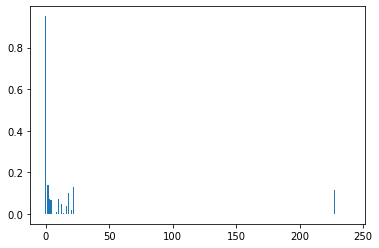

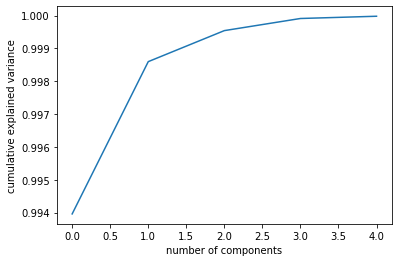

In [6]:
#KS2 school data
import numpy as np
import matplotlib.pyplot as plt
ks2_df = pd.read_csv('OFSTED\england_ks2final.csv', header= 0)
ks4_df = pd.read_csv('OFSTED\england_ks4final.csv', header= 0)
ks2_df = ks2_df[16356:] # Just take the LA data at the bottom 
ks2_df = ks2_df.loc[ks2_df['LEA'] != ' '] # remove rows without LEA codes
ks2_df = ks2_df.loc[ks2_df['LEA'] != '420'] # remove isles of scilly
ks2_df['LA code'] = ks2_df['LEA'].apply(lambda x: old2newLAcode[int(x)]) # Convert old LEA to new LA codes
#print(ks2_df.head())
ks2_df = ks2_df.set_index('LA code')
ks2_df = ks2_df.drop(columns=['RECTYPE','ALPHAIND','LEA',	'ESTAB','URN','SCHNAME','ADDRESS1',	'ADDRESS2',
	'ADDRESS3',	'TOWN','PCODE','TELNUM','PCON_CODE','PCON_NAME','URN_AC','SCHNAME_AC','OPEN_AC',
    'NFTYPE','ICLOSE','RELDENOM','AGERANGE','CONFEXAM',	'TAB15','TAB1618'])

ks2_df = ks2_df.applymap(lambda x: float(x.strip('%'))/100 if str(x).endswith('%') else x) #transform values like '17%' to 0.17
ks2_df = ks2_df.applymap(lambda x: float(x.strip('%'))/100 if str(x).endswith('%') else x) #transform values like '17%' to 0.17
print('Shape: ',ks2_df.shape)
ks2_df = ks2_df.applymap(lambda x: np.nan if x == '' or x == ' ' else x)
ks2_df.dropna(axis=1, how='any',inplace=True)


#Perform PCA on the school metrics
from sklearn.decomposition import PCA

pca = PCA(n_components=5)
pca.fit(ks2_df)
# print(pca.explained_variance_ratio_) # PC 1 has 0.99 of the variance
pc_weights = pd.DataFrame(pca.components_[0],ks2_df.keys())
# print(pc_weights.sort_values(0))

plt.bar(range(len(pca.components_[0])),pca.components_[0])
plt.show()
ks2_pca_df  = pd.DataFrame(pca.transform(ks2_df), index=ks2_df.index).rename({0:'KS2 metrics PCA'},axis=1)
# print(ks2_pca_df)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [7]:
import scipy

LAcodes_df = pd.read_csv('Local_Authority_Districts__December_2020__Names_and_Codes_in_the_United_Kingdom.csv',header=0)
LAcode2name = dict(zip(LAcodes_df['LAD20CD'],LAcodes_df['LAD20NM']))
#Add back abolished LAs
LAcode2name['E07000004'] = 'Aylesbury Vale'
LAcode2name['E07000005'] = 'Chiltern'
LAcode2name['E07000006'] = 'South Bucks'
LAcode2name['E07000007'] = 'Wycombe'
LAcode2name['E06000028'] = 'Bournemouth'
LAcode2name['E07000048'] = 'Christchurch'
LAcode2name['E06000029'] = 'Poole'
LAcode2name['E07000049'] = 'East Dorset'
LAcode2name['E07000050'] = 'North Dorset'
LAcode2name['E07000053'] = 'Weymouth and Portland'
LAcode2name['E07000051'] = 'Purbeck'
LAcode2name['E07000052'] = 'West Dorset'
LAcode2name['E07000190'] = 'Taunton Deane'
LAcode2name['E07000191'] = 'West Somerset'
LAcode2name['E07000201'] = 'Forest Heath'
LAcode2name['E07000204'] = 'St Edmundsbury'
LAcode2name['E07000205'] = 'Suffolk Coastal'
LAcode2name['E07000206'] = 'Waveney'
LAcode2name['E08000020'] = 'Gateshead'
LAcode2name['E10000023'] = 'North Yorkshire'
LAcode2name['E10000002'] = 'Buckinghamshire'
LAcode2name['E10000007'] = 'Derbyshire'
LAcode2name['E10000011'] = 'East Sussex'
LAcode2name['E10000014'] = 'Hampshire'
LAcode2name['E10000018'] = 'Leicestershire'
LAcode2name['E10000028'] = 'Staffordshire'
LAcode2name['E10000003'] = 'Cambridgeshire'
LAcode2name['E10000008'] = 'Devon'
LAcode2name['E10000012'] = 'Essex'
LAcode2name['E06000048'] = 'Northumberland'
LAcode2name['E10000006'] = 'Cumbria'
LAcode2name['E06000048'] = 'Northumberland'
LAcode2name['E06000048'] = 'Northumberland'
LAcode2name['E06000048'] = 'Northumberland'
LAcode2name['E06000048'] = 'Northumberland'


# Join the loneliness index with the migration data
main_df = migration_school_ages.join(ofsted_avg,on= 'LA code',how='outer')
main_df.columns
main_df = main_df.merge(lonely_index_average, on='LA code',how='outer')
main_df = pd.merge(main_df,ks2_pca_df,on='LA code',how='outer') #Missing some regions
main_df = pd.merge(main_df,income_df,on='LA code', how='outer') #Missing some regions

main_df = main_df.reset_index()
#main_df = main_df.loc[main_df['lonely_avg'].notna()]

print(main_df.loc[main_df['LA code'].isin(['E07000004','E07000005','E07000006','E07000007','E06000060','E06000028','E06000058'])])

#main_df = main_df.loc[main_df['Ofsted Avg'].notna()] # remove LAs from wales etc which we havent calcualted Ofsted or lonely avg




     index    LA code  Inflow  Outflow    Net  Inflow.1  Outflow.1  Net.1  \
54      54  E06000058  1148.0   1112.0   36.0     590.0      591.0   -1.0   
56      56  E07000004  1133.0    765.0  368.0     580.0      384.0  196.0   
57      57  E07000005   680.0    457.0  223.0     354.0      265.0   89.0   
58      58  E07000006   468.0    478.0  -10.0     253.0      265.0  -12.0   
59      59  E07000007   969.0    803.0  166.0     443.0      386.0   57.0   
368    368  E06000028     NaN      NaN    NaN       NaN        NaN    NaN   
384    384  E06000060     NaN      NaN    NaN       NaN        NaN    NaN   

     Inflow.2  Outflow.2  Net.2  TotalFlow  Ofsted Avg  lonely_avg  \
54      558.0      521.0   37.0     2260.0    3.066667         NaN   
56      553.0      381.0  172.0     1898.0         NaN    0.474003   
57      326.0      192.0  134.0     1137.0         NaN    0.877147   
58      215.0      213.0    2.0      946.0         NaN    0.005941   
59      526.0      417.0  109.0  

   index    LA code  Ofsted Avg  lonely_avg  KS2 metrics PCA           1  \
0      0  E06000001    3.000000   -0.542761    -22376.054139 -290.167898   
1      1  E06000002    2.955556    1.316155    -16308.990169  270.736279   
2      2  E06000003    2.791667    0.649266    -18159.719122 -184.265895   
3      3  E06000004    3.085714    0.635474    -11390.336475 -130.313185   

            2           3           4  GDHI income index  \
0 -381.330817  192.401360 -102.655960                NaN   
1 -594.655374  255.374225   96.134006                NaN   
2 -645.498998  162.261506  -65.772823               76.2   
3 -730.967601   54.773225  -28.974278               79.3   

                LA name  LA flow rate  
0            Hartlepool      0.006386  
1         Middlesbrough      0.009087  
2  Redcar and Cleveland      0.006610  
3      Stockton-on-Tees      0.006535  
                      index  Ofsted Avg  lonely_avg  KS2 metrics PCA  \
index              1.000000    0.213490   -0.1

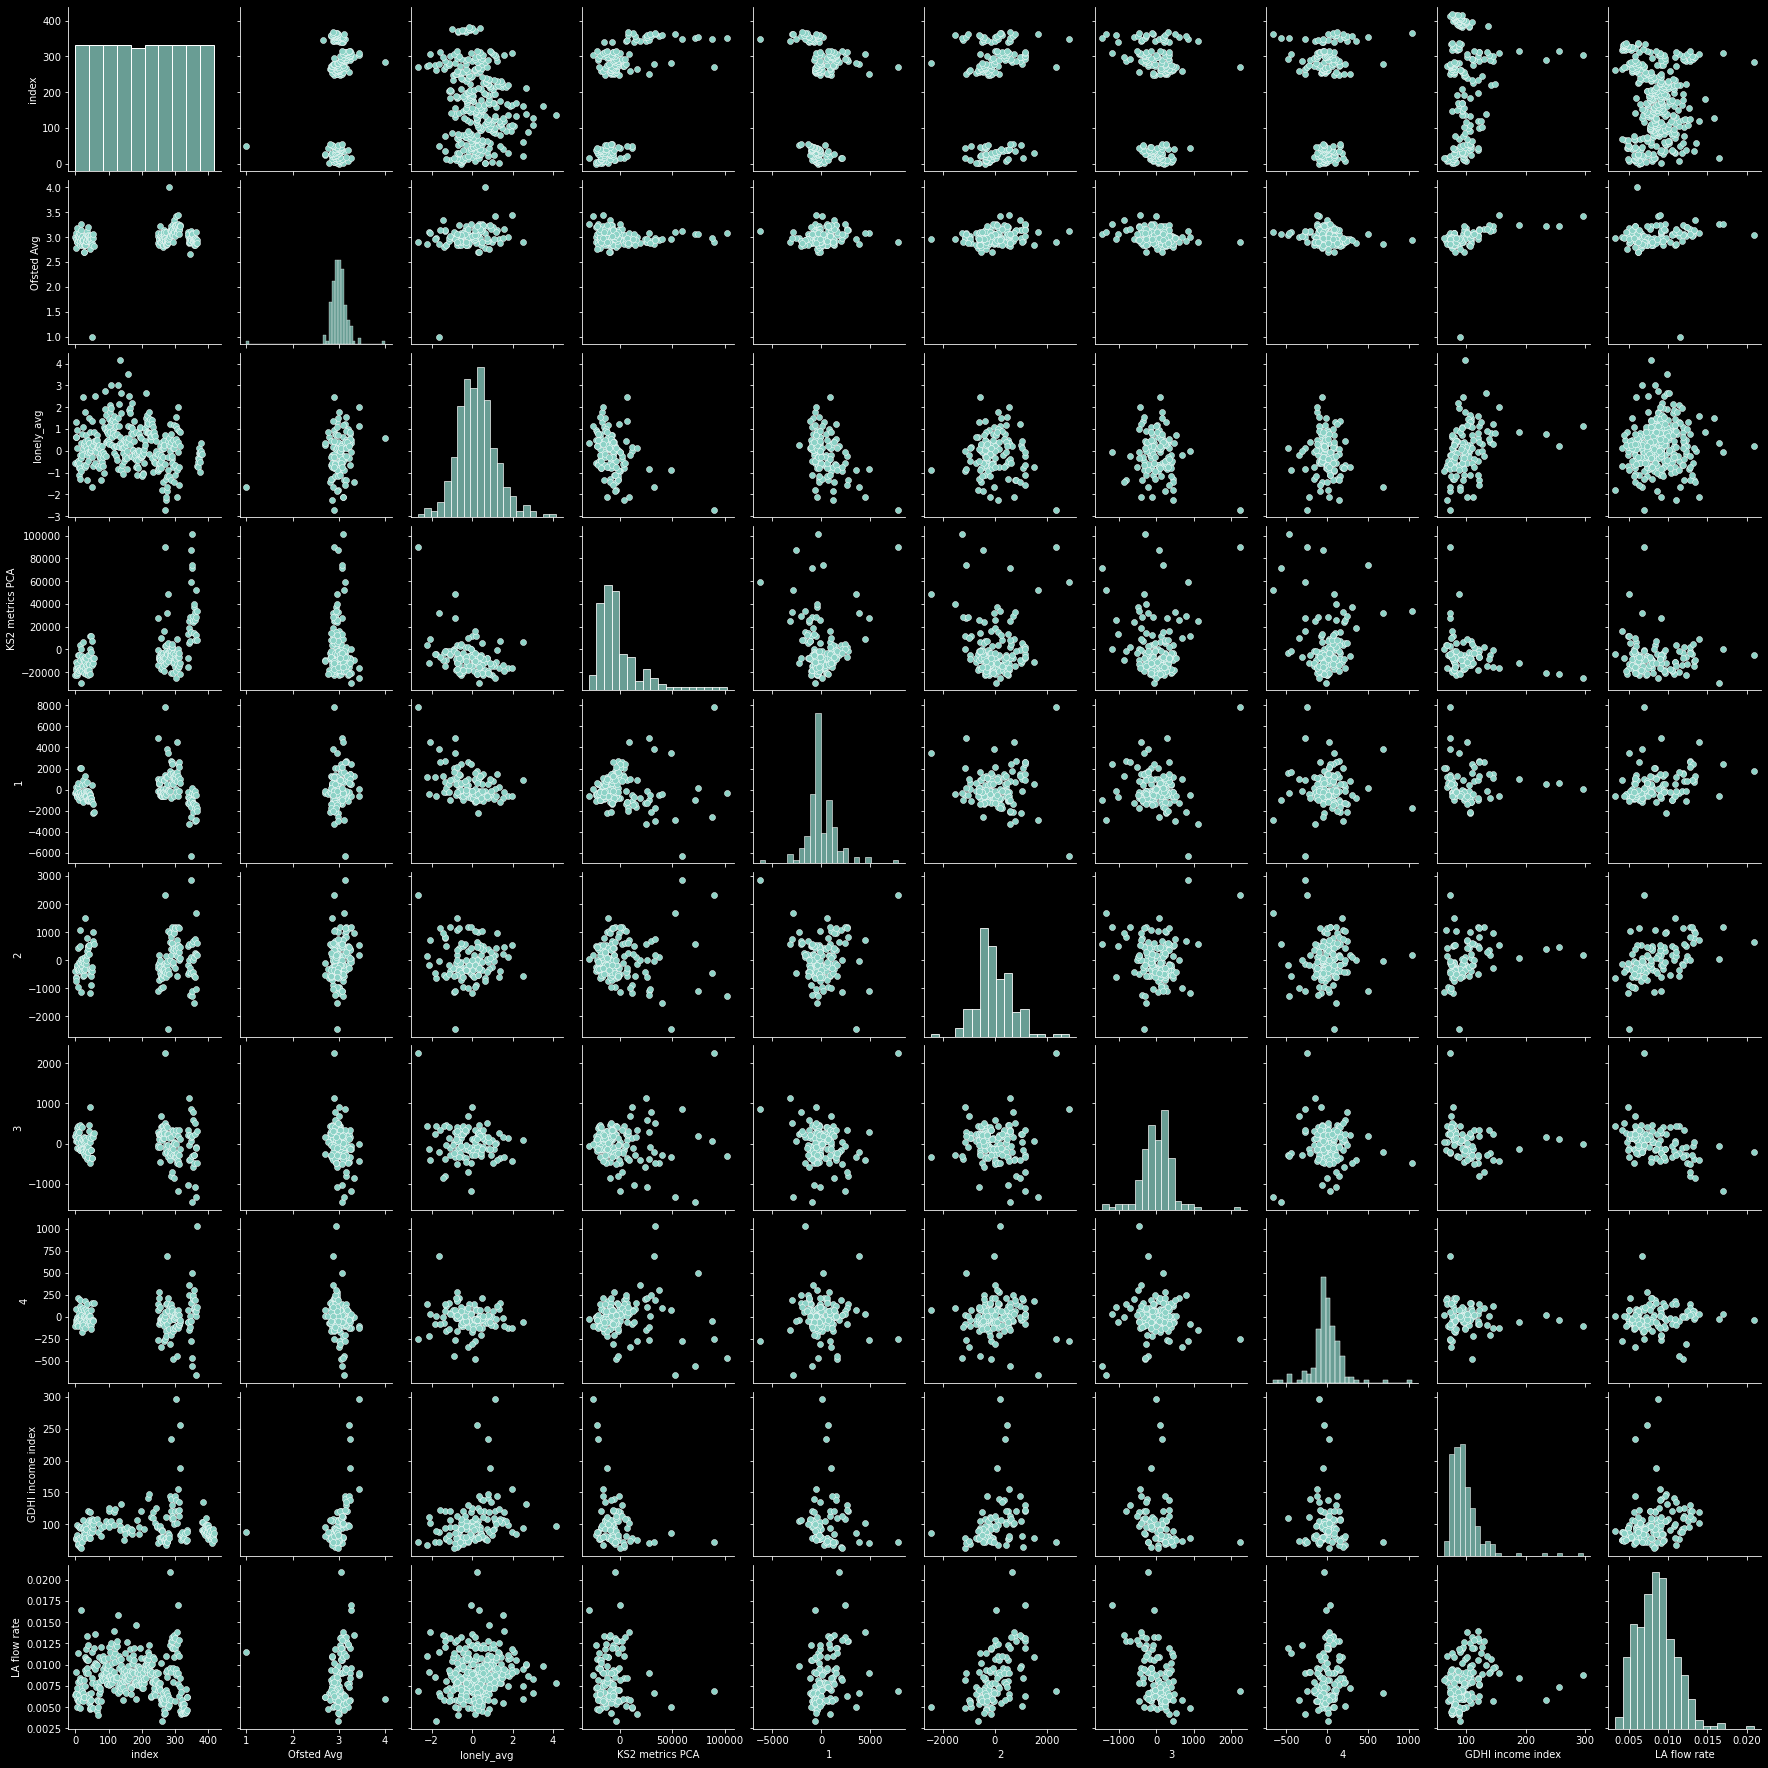

In [8]:
main_df['LA name'] = main_df['LA code'].apply(lambda x: LAcode2name.get(x,'NA'))
main_df['LA flow rate'] =  main_df['TotalFlow'] / main_df['LA code'].apply(lambda x: pop_dict.get(x,0))

# main_df['KS2_PCA_Zscore'] = scipy.stats.zscore(main_df['KS2 metrics PCA'])
# main_df = main_df.loc[main_df['KS2_PCA_Zscore'].abs() <=3]


# main_data['lonely_avg'] = pd.to_numeric(main_data['lonely_avg'])
main_vars = main_df.drop(columns=['Net', 'Inflow.1', 'Outflow.1', 'Net.1', 'Inflow.2','Outflow.2','Net.2'])
main_vars = main_vars.drop(columns=['Inflow', 'Outflow','TotalFlow'])
print(main_vars.head(4))
print(main_vars.corr())

import seaborn as sns
import matplotlib
matplotlib.style.use('dark_background')
sns.pairplot(main_vars)

We can see there is a negative correlation between average loneliness and total migration flow of school age people.
There is a positive correlation between avg ofsted rating and total migration flow 
Perhaps higher total flow seems to coincide with lower loneliness index

In [9]:
main_vars.drop(columns=['index'],inplace=True)
print(main_vars.head())
main_vars.to_csv('SchoolRankingIncome.csv',index=False)

     LA code  Ofsted Avg  lonely_avg  KS2 metrics PCA           1           2  \
0  E06000001    3.000000   -0.542761    -22376.054139 -290.167898 -381.330817   
1  E06000002    2.955556    1.316155    -16308.990169  270.736279 -594.655374   
2  E06000003    2.791667    0.649266    -18159.719122 -184.265895 -645.498998   
3  E06000004    3.085714    0.635474    -11390.336475 -130.313185 -730.967601   
4  E06000005    2.894737    0.967079    -22128.626436 -467.059770 -238.721080   

            3           4  GDHI income index               LA name  \
0  192.401360 -102.655960                NaN            Hartlepool   
1  255.374225   96.134006                NaN         Middlesbrough   
2  162.261506  -65.772823               76.2  Redcar and Cleveland   
3   54.773225  -28.974278               79.3      Stockton-on-Tees   
4   78.064856   -0.633393               82.8            Darlington   

   LA flow rate  
0      0.006386  
1      0.009087  
2      0.006610  
3      0.006535  
4 

In [10]:
print(main_vars.loc[main_vars['LA code'].isin(['E07000004','E07000005','E07000006','E07000007'])])
print(main_vars.loc[main_vars['LA code'].isin(['E10000034'])])

      LA code  Ofsted Avg  lonely_avg  KS2 metrics PCA   1   2   3   4  \
56  E07000004         NaN    0.474003              NaN NaN NaN NaN NaN   
57  E07000005         NaN    0.877147              NaN NaN NaN NaN NaN   
58  E07000006         NaN    0.005941              NaN NaN NaN NaN NaN   
59  E07000007         NaN   -0.553051              NaN NaN NaN NaN NaN   

    GDHI income index         LA name  LA flow rate  
56                NaN  Aylesbury Vale      0.009683  
57                NaN        Chiltern      0.011924  
58                NaN     South Bucks      0.013556  
59                NaN         Wycombe      0.010140  
       LA code  Ofsted Avg  lonely_avg  KS2 metrics PCA            1  \
367  E10000034    2.882883         NaN      7967.724965 -2019.711764   

              2           3           4  GDHI income index LA name  \
367  602.651742  307.845442  117.329694                NaN      NA   

     LA flow rate  
367           NaN  
